In this project, I investigate the demographics most impacted by food deserts. Food deserts can be defined in several different ways relating to distance, income and household accessibility to a vehicle. I use [this data and the following definition from the USDA](https://www.ers.usda.gov/data-products/food-access-research-atlas/download-the-data/):

* Low income
* Limited access to supermarkets, supercenters, grocery stores, or other sources of healthy and affordable food retailers
* 1+ mile was used in urban areas
* 10+ miles was used in rural areas

I start by looking purely at low access to supermarkets to get an idea of how the population is dispersed (i.e. who lives far from a supermarket). Next, I incorporate low income into the model per the USDA definition. Finally, I use the low access, low income definition as described and specifically look at race/nationality (removing any features related to income) to see who is most affected by food deserts.

By using a logistic regression model, I can look at the coefficients to get an idea of which regressors have the largest impact on the model.

Start by importing some basic packages and the scikit-learn `LogisticRegression` class.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt

Load in the data here. The data comes in one Excel file with multiple sheets which I have separated into 2 CSV files. `pd.read_excel` is painfully slow compared to `pd.read_csv`, so this simple switch greatly improves efficiency here. The features within the dataframe are all abbreviated, so I also load the `variables` dataframe which holds the definitions of the abbreviations.

In [2]:
variables = pd.read_csv('food_desert_data_variables.csv')
df = pd.read_csv('food_desert_data.csv')

In [3]:
df.shape

(72864, 147)

There are over 72,000 census tracts in this dataset, each with 147 features. Many of these features are grouped based on which definition of a food desert we are using. Below I call out only the features related to the distance definition described at the beginning, which are noted by `1share`. I also append `LA1and10` and `LILATracts_1And10`, which are flags the USDA has created to note whether the tract is simply "low access" ("LA") or "low income, low access", ("LILA") the latter constituting a food desert.

* "LA" = "low access"
* "LILA" = "low income, low access"

It's important to note this dataset has features for both raw counts and proportions for the various demographics. I have elected to use the proportions (designated by `share` in the feature name) to save time normalizing the features later.

This is just a little function I wrote to print out the various section titles more attractively.

In [4]:
def title_print(text):
    '''
    Used throughout to print section titles
    '''
    text_len = len(text)
    print()
    print('#' * (text_len + 4))
    print('#', text, '#')
    print('#' * (text_len + 4))

In [5]:
features = [i for i in df.columns if '1share' in i]
features.extend(['LA1and10', 'LILATracts_1And10'])
df = df[features]
title_print('Features')
[[variables[variables['Field'] == i]['Description'].values[0]] for i in features]


############
# Features #
############


[['Share of tract population that are beyond 1 mile from supermarket'],
 ['Share of tract population that are low income individuals beyond 1 mile from supermarket'],
 ['Share of tract population that are kids beyond 1 mile from supermarket'],
 ['Share of tract population that are seniors beyond 1 mile from supermarket'],
 ['Share of tract population that are white beyond 1 mile from supermarket'],
 ['Share of tract population that are Black or African American beyond 1 mile from supermarket'],
 ['Share of tract population that are Asian beyond 1 mile from supermarket'],
 ['Share of tract population that are Native Hawaiian or Other Pacific Islander beyond 1 mile from supermarket'],
 ['Share of tract population that are American Indian or Alaska Native beyond 1 mile from supermarket'],
 ['Share of tract population that are Other/Multiple race beyond 1 mile from supermarket'],
 ['Share of tract population that are of Hispanic or Latino ethnicity beyond 1 mile from supermarket'],
 ['Shar

There are 0 null or missing values, which is great.

In [6]:
print('Missing values: {}'.format(df.isnull().sum().sum()))

Missing values: 0


However, there are over 21,000 tracts with no information on demographics whatsoever. Since I can't actually get any useful information from these, I drop them below.

In [7]:
index_to_drop = df[(df[df.columns] == 0).T.all()].index
print('Tracts with no info: {}'.format(len(index_to_drop)))
df = df.drop(index_to_drop).reset_index(drop = True)

Tracts with no info: 21345


Below is a heatmap which shows the correlation between the features I am examining. Some of these are rather obvious, e.g. low income is highly correlated with receiving SNAP benefits. It's really interesting to note the strong correlations in top left quadrant. `lapop1share` is the first column and represents the "share of tract population that are beyond 1 mile from supermarket". When looking down that column, notice the extremely strong correlations with kids (0-17 year olds) and white households, and the slightly lower (but still strong) correlation with seniors and low income. When used in conjunction with the coefficients of the regressors we get below, this will give us a good idea of who is most affected by food deserts.

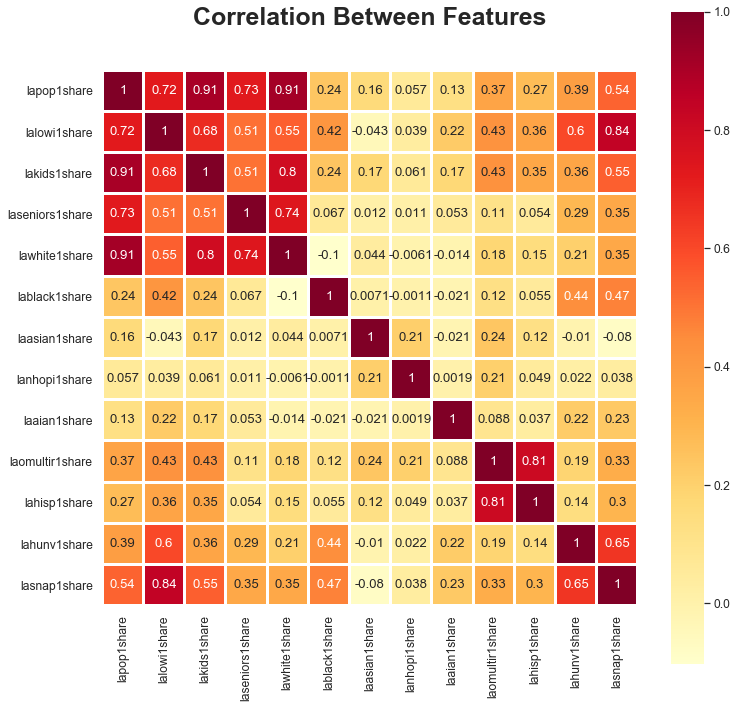

In [8]:
sns.set(font_scale = 1.1)
corrmat = df[df.columns[:-2]].corr()
f_corr, ax_corr = plt.subplots(figsize = (12, 12))
sns.heatmap(corrmat, ax = ax_corr, annot = True,
            cmap = 'YlOrRd',
            linewidths = 2.0,
            square = True)
ax_corr.set_title('Correlation Between Features',
                  fontsize = 25,
                  fontweight = 'bold',
                  pad = 45)
plt.show()

Here I separate the regressor variables from the response variables. I run the logistic regression three times: once with the "low access" flag, once with the "low access, low income" flag to see if there are any differences, and finally with the "low access, low income" flag while specifically looking at race/nationality.

In [9]:
X = pd.DataFrame(df[df.columns[:-2]])

la_y = pd.DataFrame(df[df.columns[-2]])
lila_y = pd.DataFrame(df[df.columns[-1]])

This is where I actually run the logistic regression. I create a function so I can run it with different response (`y`) variables and compare them. This function will give a model score as a sanity check to make sure I haven't created some completely random model and prints out the `n_top` coefficients of the model based on absolute value. These will show which features have the highest impact on the resulting response variable (food desert `1`, or not `0`) and give us insight into how the model is classifying inputs.

In [10]:
def logistic_reg(X, y, test_size, max_iters, n_top):
    '''
    Performs logistic regression on X, y
        X: regressor (independent) variables
        y: response variable
        test_size (float): 0-1, ratio of test set
        max_iters (int): max iterations to run until convergence
        n_top (int): number of top coefficients to print out after running regression
    '''
    title_print(y.columns[0])
    
    # Split train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size = test_size,
                                                        random_state = 42)
    
    # Create model
    logr = LogisticRegression(max_iter = max_iters)
    logr.fit(X_train, y_train.to_numpy().ravel())
    
    # Check score for sanity
    print('Logistic regression score: {}%'.
          format(100 * round(logr.score(X_test, y_test), 4)))
    
    # Check coefficients
    coeff = pd.DataFrame(logr.coef_[0], X.columns, columns = ['Coefficient'])
    title_print('Coefficients')
    print(coeff)
    title_print('Intercept')
    print(logr.intercept_[0])
    
    # Top n high impact regressor variables
    title_print('Top regressors')
    high_reg = abs(coeff).nlargest(n = n_top, columns = 'Coefficient').index
    for i in high_reg:
        print(variables[variables['Field'] == i]['Description'].values[0] +
              ':\n' + str(round(coeff.loc[i][0], 4)))
        print()

I first run the regression looking only at low access tracts (i.e. not specifically accounting for income).

In [11]:
logistic_reg(X, la_y, test_size = 0.2, max_iters = 500, n_top = 5)


############
# LA1and10 #
############
Logistic regression score: 67.61%

################
# Coefficients #
################
                 Coefficient
lapop1share         4.965457
lalowi1share       -2.178943
lakids1share        2.281201
laseniors1share     2.634104
lawhite1share      -5.457273
lablack1share      -2.058804
laasian1share      19.835349
lanhopi1share      -1.494469
laaian1share       -3.706094
laomultir1share    -2.153253
lahisp1share        2.859889
lahunv1share        7.273740
lasnap1share       -1.513174

#############
# Intercept #
#############
-0.44443636456086016

##################
# Top regressors #
##################
Share of tract population that are Asian beyond 1 mile from supermarket:
19.8353

Share of tract housing units that are without vehicle and beyond 1 mile from supermarket:
7.2737

Share of tract population that are white beyond 1 mile from supermarket:
-5.4573

Share of tract population that are beyond 1 mile from supermarket:
4.9655

Share of 

This is very interesting. When looking at the heatmap above, there is a very low correlation between the Asian population and low access to supermarkets based on distance. However, in this logistic regression, the feature which represents the "share of tract population that are Asian beyond 1 mile from supermarket" has the largest coefficient and therefore impact on the response variable by far. On the other hand, the share of the population that is either white, American Indian or Alaka Native actually all have a negative influence on the response variable here.

Now I'll look at low income and low access to get a understanding of which demographics are specifically impacted by food deserts. Recall that the definition of a food desert that I am using takes into account both accessibility and income.

In [12]:
logistic_reg(X, lila_y, test_size = 0.2, max_iters = 500, n_top = 5)


#####################
# LILATracts_1And10 #
#####################
Logistic regression score: 85.75%

################
# Coefficients #
################
                 Coefficient
lapop1share        -1.900921
lalowi1share       10.324673
lakids1share       -4.322084
laseniors1share     0.840708
lawhite1share      -2.638784
lablack1share      -0.320109
laasian1share       0.195357
lanhopi1share      -0.311781
laaian1share       -2.624841
laomultir1share     3.799237
lahisp1share        0.991315
lahunv1share        7.163040
lasnap1share        3.886499

#############
# Intercept #
#############
-1.701692465982661

##################
# Top regressors #
##################
Share of tract population that are low income individuals beyond 1 mile from supermarket:
10.3247

Share of tract housing units that are without vehicle and beyond 1 mile from supermarket:
7.163

Share of tract population that are kids beyond 1 mile from supermarket:
-4.3221

Share of tract housing units receiving SNAP 

So now we can see that being low income actually represents the largest predictor of the response variable. Combined with the second regressor variable representing housing units that don't have access to a vehicle, this represents a major logistical challenge for some households. Being geographically far away from nutritious food with limited access to transportation can create a nutriotional deficit.

It may be obvious that including low income in the flag leads to the low income regressor having the largest impact. If we remember that a food desert by definition is low income, we can remove all features related to income (e.g. SNAP benefits, access to vehicle) from our model. I run the regression model one more time using only race/nationality features and the low income/low access flag.

In [13]:
nat_features = ['lawhite1share', 'lablack1share', 'laasian1share',
                'lanhopi1share', 'laaian1share', 'laomultir1share',
                'lahisp1share', 'LILATracts_1And10']

In [14]:
nat_df = df[nat_features]
nat_X = pd.DataFrame(nat_df[nat_df.columns[:-1]])
nat_y = pd.DataFrame(nat_df[nat_df.columns[-1]])

In [15]:
logistic_reg(nat_X, nat_y, test_size = 0.2, max_iters = 500,
             n_top = len(nat_features) - 1)


#####################
# LILATracts_1And10 #
#####################
Logistic regression score: 83.63000000000001%

################
# Coefficients #
################
                 Coefficient
lawhite1share      -1.030045
lablack1share       4.526760
laasian1share      -6.593053
lanhopi1share       0.990776
laaian1share        2.874963
laomultir1share     5.828009
lahisp1share        2.683019

#############
# Intercept #
#############
-1.6879577044875902

##################
# Top regressors #
##################
Share of tract population that are Asian beyond 1 mile from supermarket:
-6.5931

Share of tract population that are Other/Multiple race beyond 1 mile from supermarket:
5.828

Share of tract population that are Black or African American beyond 1 mile from supermarket:
4.5268

Share of tract population that are American Indian or Alaska Native beyond 1 mile from supermarket:
2.875

Share of tract population that are of Hispanic or Latino ethnicity beyond 1 mile from supermarket:

Finally we get a pretty clear picture of who is affected by food deserts. Once again, the most influential feature is Asian population, however now it has a negative impact on the response! In the first regression, I only factored in distance to supermarkets, and didn't account for income at all. Therefore all I can say is that those coefficients are related to how far households are from supermarkets. In this last regression, I remove features related to income, but use a response variable that factors income in. When looking at these two regressions together, it suggests to me that while Asian households may live geographically far from supermarkets, they are likely overall more wealthy. It would require a totally separate analysis to prove that hypothesis, however.

When I remove any feature directly related to income - which will obviously have a large coefficient when predicting a response variable related to income - and look only at race/nationality, households that are multiracial or Black/African American are most impacted by food deserts.